In [2]:
# Connect to Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# do all of the imports
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
import joblib

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
# Utility Function for history plotting
# adapted from a RealPython tutorial: 
#    https://realpython.com/python-keras-text-classification/
def plot_history(history, file_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig(file_name, bbox_inches='tight')

In [5]:
# Utility Function for data cleaning pipeline
def text_pipeline(row):
    genre = row["genre"]
    descr = row["description"]
    text = genre + " " + descr
    # split into words
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # join the words and return them to be loaded into the dataframe
    return " ".join(words)

In [ ]:
!ls gdrive/MyDrive/Colab\ Notebooks/Final-Project/Resource/
!pwd

In [6]:
# Load in the IMDB_sean file
df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Final-Project/Resource/IMDB_sean.csv")
df.head()

,Unnamed: 0,title,year,genre,description,budget,usa_gross_income,worlwide_gross_income,profit_factor
0,165,Il gabinetto del dottor Caligari,1920,"Fantasy, Horror, Mystery","Hypnotist Dr. Caligari uses a somnambulist, Ce...",18000.0,8811.0,8811.0,loss
1,245,I quattro cavalieri dell'Apocalisse,1921,"Drama, Romance, War",An extended family split up in France and Germ...,800000.0,9183673.0,9183673.0,large gain
2,506,Metropolis,1927,"Drama, Sci-Fi",In a futuristic city sharply divided between t...,6000000.0,1236166.0,1349711.0,loss
3,1048,Luci della città,1931,"Comedy, Drama, Romance","With the aid of a wealthy erratic tippler, a d...",1500000.0,19181.0,46008.0,loss
4,2454,Tempi moderni,1936,"Comedy, Drama, Family",The Tramp struggles to live in modern industri...,1500000.0,163577.0,457688.0,loss


In [7]:
 # Run the Genre and Description thru the text pipeline for joining and cleaning
 df["words"] = df.apply(text_pipeline, axis=1)
 df.head()
 print(df["words"].map(lambda x: len(x)).max())

315


In [8]:
# Define the X and y parameters
sentences = df["words"].values
y = df["profit_factor"].values

print(f"Shape sentences: {np.shape(sentences)}")

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

print(f"Shape sentences_train: {np.shape(sentences_train)}")
print(f"Shape sentences_test: {np.shape(sentences_test)}")

tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

print(f"Shape X_train: {np.shape(X_train)}")
print(f"Shape X_test: {np.shape(X_test)}")

vocab_size = len(tokenizer.word_index) + 1 # adding 1 due to reserved 0 index
print(f"vocab_size:{vocab_size}")

# Label Encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)
print(encoded_y_test)
print(f"Shape encoded_y_test: {np.shape(encoded_y_test)}")

Shape sentences: (8109,)
Shape sentences_train: (6081,)
Shape sentences_test: (2028,)
Shape X_train: (6081,)
Shape X_test: (2028,)
vocab_size:15868
[1 3 3 ... 1 0 0]
Shape encoded_y_test: (2028,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [9]:
# Pad the data
maxlen = 315
X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)
print(f"Shape X_train: {np.shape(X_train)}")
print(f"Shape X_test: {np.shape(X_test)}")

Shape X_train: (6081, 315)
Shape X_test: (2028, 315)


In [10]:
# Keras Embedding Layer
embedding_dim = 5
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(500, activation="relu"))
model.add(layers.Dense(50, activation="sigmoid"))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 315, 5)            79340     
_________________________________________________________________
flatten (Flatten)            (None, 1575)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               788000    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                25050     
Total params: 892,390
Trainable params: 892,390
Non-trainable params: 0
_________________________________________________________________


In [11]:
print(f"Shape X_test: {np.shape(X_test)}")

Shape X_test: (2028, 315)


In [14]:
# Train the model and gather results
X_test_np = np.array(X_test).astype('float32')
X_train_np = np.array(X_train).astype('float32')
encoded_y_test_np = np.array(encoded_y_test).astype('float32')
encoded_y_train_np = np.array(encoded_y_train).astype('float32')

history = model.fit(X_train_np, encoded_y_train_np,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_np, encoded_y_test_np),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train_np, encoded_y_train_np, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_np, encoded_y_test_np, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
# Save the Model
file_name = "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/sean_Neural_Net_1.h5"
model.save(file_name)

Training Accuracy: 0.9990
Testing Accuracy:  0.2811


In [17]:
# print(f"history keys: {history.keys}")
# print(f"history.history.keys: {history.history.keys}")
for key, value in history.history.items() :
    print (key, value)

loss [0.003805202664807439, 0.003294791327789426, 0.003538974793627858, 0.0038858980406075716, 0.00339641235768795, 0.0030344233382493258, 0.0027065672911703587, 0.0037095409352332354, 0.003004975151270628, 0.0024744293186813593, 0.0036160557065159082, 0.0025732398498803377, 0.002835107734426856, 0.002979155397042632, 0.00479520671069622, 0.0018802444683387876, 0.003314342349767685, 0.002675800584256649, 0.0029016025364398956, 0.0022411865647882223]
accuracy [0.9985199570655823, 0.9990133047103882, 0.9990133047103882, 0.9985199570655823, 0.9988488554954529, 0.9988488554954529, 0.9988488554954529, 0.9985199570655823, 0.998355507850647, 0.9990133047103882, 0.9986844062805176, 0.9990133047103882, 0.9986844062805176, 0.9990133047103882, 0.9986844062805176, 0.9991777539253235, 0.9988488554954529, 0.9990133047103882, 0.9990133047103882, 0.9988488554954529]
val_loss [7.93757438659668, 8.713080406188965, 8.693583488464355, 8.680827140808105, 8.10777473449707, 8.543740272521973, 8.3449516296386

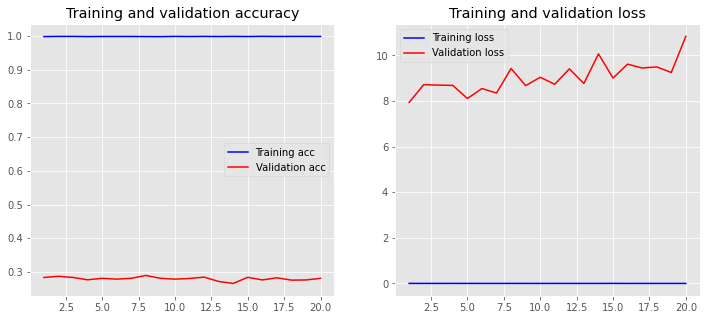

In [19]:
plot_history(history, "gdrive/MyDrive/Colab Notebooks/Final-Project/Images/NeuralNet1.png")